# Personalized GWAP (Genome wide association & PageRank)
____
This python notebook walks through our implementation of the Personalized PageRank algorithm for the analysis of genome wide association studies using gene-gene networks.  

This was developed by Bethany Fixsen, Erica Silva, and Hunter Bennett

In [1]:
# import modules
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from ndex.networkn import NdexGraph
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split

%matplotlib inline

set working directory

In [2]:
workingDir = '/home/h1bennet/final_project/'
os.chdir(workingDir)

# Part 1: SNP/Gene Mapping within TADs
_______
The pipeline for mapping snps and genes within TADs was developed by Bethany Fixsen.  

cortical plate TADs: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE77565 (GSE77565_CP_TAD.bed.gz)  
SNPs and genes were hg18 and TADs were mapped to hg19. Therefore, I used UCSC 'liftover' to convert the TAD coordinates to hg18 assembly. The lifted-over file is called GSE77565_hg18.bed. 

In [3]:
# import tad file
tads = pd.read_csv('./data/GSE77565_hg18.bed',
                   delim_whitespace = True, header=None,
                   names=['chr', 'start', 'end', 'id'])
# import snps file
snps = pd.read_csv('./data/snp_level_summary_stats_pmid_25056061.txt',
                   delim_whitespace=True)
#match hg18 column id
snps['hg18chr'] = 'chr'+snps['hg18chr'].astype(str)

### Plot tad size distribution

In [4]:
size = tads.end - tads.start

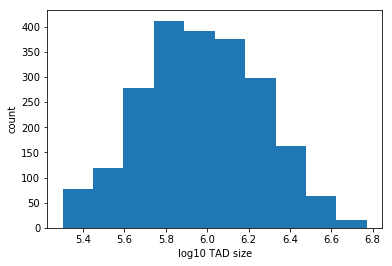

In [5]:
plt.hist(np.log10(size))
plt.xlabel('log10 TAD size')
plt.ylabel('count')

### Save snps in the bed format

In [6]:
snps.loc[:, ['hg18chr', 'bp', 'bp', 'snpid', 'pval']]\
    .to_csv('./data/snp_level_summary_stats_pmid_25056061.bed', header=None,
            index=None, sep='\t')

### Intersect SNPS and geneswith each individual TAD

In [7]:
%%bash
# TAD gene intersect
bedtools intersect -a ./data/GSE77565_hg18.bed -b ./data/gene_bed_df.bed -wa -wb > ./results/TAD_gene_intersect_06062018.bed
# Tad SNP intersect
bedtools intersect -a ./data/snp_level_summary_stats_pmid_25056061.bed -b ./data/GSE77565_hg18.bed -wa -wb > ./results/SNP_TAD_overlap_06062018.bed

### Import intersections back into pandas

In [8]:
tad_gene = pd.read_csv('./results/TAD_gene_intersect_06062018.bed',
                       delim_whitespace=True, header=None,
                       names=['tad_chr', 'tad_start', 'tad_end',
                              'tad_id', 'gene_chr', 'gene_start',
                              'gene_end', 'gene_id'])


In [9]:
tad_snp = pd.read_csv('./results/SNP_TAD_overlap_06062018.bed',
                      delim_whitespace=True, header=None,
                      names=['snp_chr', 'snp_start', 'snp_end',
                             'snp_id', 'snp_pval', 'tad_chr',
                             'tad_start', 'tad_end', 'tad_id'])

### Iterate over TADs, writing SNPs within TAD and Genes within TAD to individual bed files for use in bedtools

In [10]:
#grouping SNPs by TADs
grouped_SNP = tad_snp.groupby('tad_id')

#grouping genes by TADs 
grouped_gene = tad_gene.groupby('tad_id')

In [11]:
if not os.path.exists('./results/tad_gene/'):
    os.mkdir('./results/tad_gene/')

if not os.path.exists('./results/tad_snp/'):
    os.mkdir('./results/tad_snp/')

#Separating TADs with the genes they contain. Also separating TADs with the SNPs they contain
for name, group in grouped_gene: 
    tmp_group = group.loc[:, ['gene_chr', 'gene_start', 'gene_end', 'gene_id']]
    tmp_group.sort_values(by=['gene_chr', 'gene_start'], inplace=True)
    tmp_group.to_csv('./results/tad_gene/TAD'+str(int(name))+'.bed',
                     sep='\t', index=False, header=False)
    
    tmp_snp = grouped_SNP.get_group(int(name))\
        .loc[:, ['snp_chr', 'snp_start', 'snp_end', 'snp_id', 'snp_pval']]
    tmp_snp.sort_values(by=['snp_chr', 'snp_start'], inplace=True)
    tmp_snp.to_csv('./results/tad_snp/TAD'+str(int(name))+'.bed',
                   sep='\t', index=False, header=False)   


### Use bedtools closest to match closest snp to gene

In [12]:
%%bash
if [ ! -d ./results/tad_closest/ ]; then mkdir ./results/tad_closest; fi

for gene_bed in ./results/tad_gene/*;
do snp_bed=${gene_bed/tad_gene/tad_snp};
# snp_sort=${snp_bed/.bed/_sorted.bed}
# gene_sort=${gene_bed/.bed/_sorted.bed}
output_bed=${gene_bed/tad_gene/tad_closest}

# bedtools sort -chrThenSizeA -i $snp_bed > $snp_sort
# bedtools sort -chrThenSizeA -i $gene_bed > $gene_sort

bedtools closest -a $snp_bed -b $gene_bed -D a > $output_bed
done;

# method one for mapping - pick lowest, closest gene
rm ./results/tad_closest/gene_tad_mapping.bed
cat ./results/tad_closest/* > ./results/tad_closest/gene_tad_mapping.bed

### Import bedtools gene_tad_mapping

In [13]:
gene_snp_tad = pd.read_csv('./results/tad_closest/gene_tad_mapping.bed',
                           delim_whitespace=True,
                           names=['snp_chr', 'snp_start',
                                  'snp_end', 'snp_id',
                                  'snp_pval', 'gene_chr',
                                  'gene_start', 'gene_end',
                                  'gene_id', 'distance'])
gene_snp_tad['distance'] = np.abs(gene_snp_tad['distance'])
gene_to_snp = gene_snp_tad.iloc[:, :].groupby('gene_id')

### Assign snp p value to genes.
_____  
We use two approaches here: 
* Pick closest snp to gene (ties broken by lowest p value)
* Pick lowest p value within 10kb WITHIN TAD

In [14]:
# initialize score dicts
SNP_gene_dict = {}
for gene, frame in gene_to_snp:
    #print(gene)
    # select closest gene, most sig p value if there is a tie
    min_dist = frame.distance.min()
    min_entries = frame.loc[frame.distance == min_dist, :]
    #print(min_entries)
    #print(min_dist)
    # select most significant p value within 10kb but within tad
    min_entries_10kb = frame.loc[frame.distance <= 10**5, :]
    SNP_gene_dict[gene] = (min_entries.snp_pval.min(),
                           min_entries_10kb.snp_pval.min())
    #print(min_entries.snp_pval.min())
    #print(min_entries_10kb.snp_pval.min())

tad_snp_map = pd.DataFrame(SNP_gene_dict,
                           index=['closest', 'min_10kb']).T


In [15]:
tad_snp_map.shape

(12710, 2)

### merge our snp-gene pairings with the ones provided in class
_____
We'd rather not lose the p values that we were unable to assign with this method so instead we will just reassign gene p values if our method was able to successfully link them, if our method did not work for a given gene then we will use the snps provided by Dan Carlin.

In [16]:
# import gene_snp map
carlin_gene_snps = pd.read_csv('./data/gene_level_summary_stats_pmid_25056061.txt',
                        sep='\t', index_col=1)['TopSNP P-Value']
closest_pval = carlin_gene_snps
top_p_10kb_tad = carlin_gene_snps

for gene, (i, j) in SNP_gene_dict.items():
    closest_pval[gene] = i
    top_p_10kb_tad[gene] = j

# Part 2: Import Networks
____


The networks used here were selected, evaluated, and imported into networkx by Erica Silva. The ipython notebooks for this section are in the network_processing folder

In [17]:
# import PCNet
pcnet = NdexGraph(server='http://ndexbio.org', uuid='f93f402c-86d4-11e7-a10d-0ac135e8bacf')

# rename nodes to be gene names
pcnet = nx.relabel_nodes(pcnet, nx.get_node_attributes(pcnet, 'name'))
pcnet = nx.Graph(pcnet)

In [18]:
# weighted pcnet
with open('./data/networks/pcnet_wt', 'rb') as f:
    pcnet_wt = nx.read_gpickle(f)
    
f.close()

In [19]:
# nwnet/GIANT
with open('./data/networks/nwnet', 'rb') as f:
    nwnet = nx.read_gpickle(f)
f.close()

nwnet = nx.relabel_nodes(nwnet, nx.get_node_attributes(nwnet, 'name'))

# Part 3: Implement and run personalized PageRank algorithm for GWAS
____
The code for the implementation of personalized PageRank and the evaluation metrics were developed by Hunter Bennett. Erica Silva, Bethany Fixsen, and Hunter Bennett all contributed to the evaluation of results

### define functions to run and evaluate personal GWAP

In [20]:
def personal_gwap(G, pvals,
                  sig_cutoff=8, alpha=0.85,
                  max_iter=100, weight=None):
    '''Run Personalized Genome Wide Association PageRank (personal gwap)
    inputs.
    Two options for running:
    1. sig_cutoff = None --> use all genes passed to algorithm
    2. sig_cutoff = int/float --> only use genes passing sig thresh
    limit genes passing genome wide significance threshold.
    G: networkx network upon which to propogate signal
    gene_series: pandas series in which the indices are genes
    and the entries are -log10 pvalues
    sig_cutoff: -log10 pvalue used to select significant genes
    alpha: alpha parameter to feed into personalizd page rank
    max_iter: max_iter paramter to feed into personalized page rank
    RETURNS:
    score: mean pagerank score across ppr propagated genes'''
    
    # create series of gene-pval associations for genes within network
    genes = list(G.nodes())
    gene_series = pd.Series(dict(zip(
        pvals.loc[genes].index.values,
        np.abs( np.log10( pvals[genes].fillna(1) ) )))) 
    
    #select only gwas significant genes if sig_cutoff is set
    if sig_cutoff != None:
        sig_genes = gene_series[gene_series >= sig_cutoff]

    bool_mem = [1 if gene in sig_genes else 0 for gene in genes]
    norm_mem = [i / sum(bool_mem) for i in bool_mem]
    
    v = dict(zip(genes, norm_mem))
    
    pr_res = nx.pagerank(G, alpha=alpha, personalization=v,
                         max_iter=max_iter, weight=weight)
    
    return pd.Series(pr_res)

def pr_curve(test_in, score_in, ax):
    '''calculates average precision and plots PR curve
    INPUTS:
    test = array of labels that should be recovered
    score = array of scores returned by method
    OUTPUTS:
    average precision: average precision of test/score'''
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    # only test on genes in both sets
    shared_genes = set(score_in.dropna().index.values).intersection(
        set(test_in.dropna().index.values))
    test = test_in[shared_genes]
    score = score_in[shared_genes]
    
    # calculate average precision
    average_precision = average_precision_score(test, score)

    # create precision recall curve
    precision, recall, _ = precision_recall_curve(test, score)

    # plot the curve
    ax.step(recall, precision, color='b', alpha=0.2,
             where='post')
    ax.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('AP={0:0.2f}'.format(
        average_precision))
    
    return average_precision

### Run Algorithm on full network
____

#### Prepare gene list with genes and p values within network

In [28]:
score_pcnet = personal_gwap(pcnet, closest_pval)

0.093927118278361532

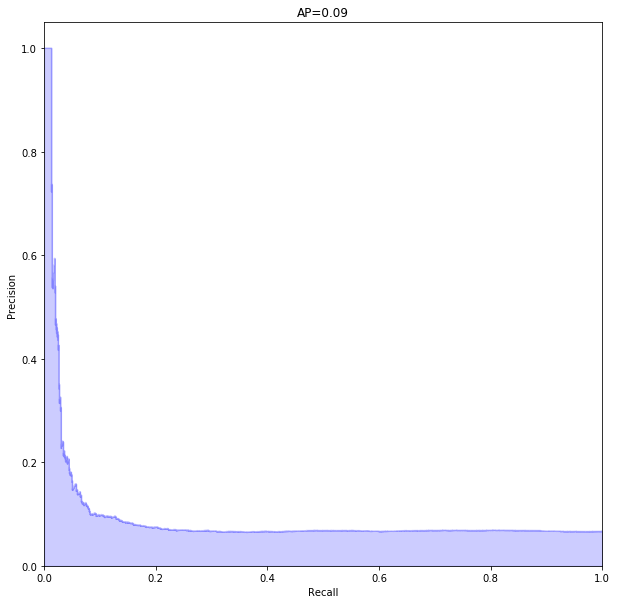

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
pr_curve(closest_pval.rank() <= 1000, score_pcnet, ax)

In [30]:
score_pcnet_weighted = personal_gwap(pcnet_wt, closest_pval, weight='p')

0.092481670200671981

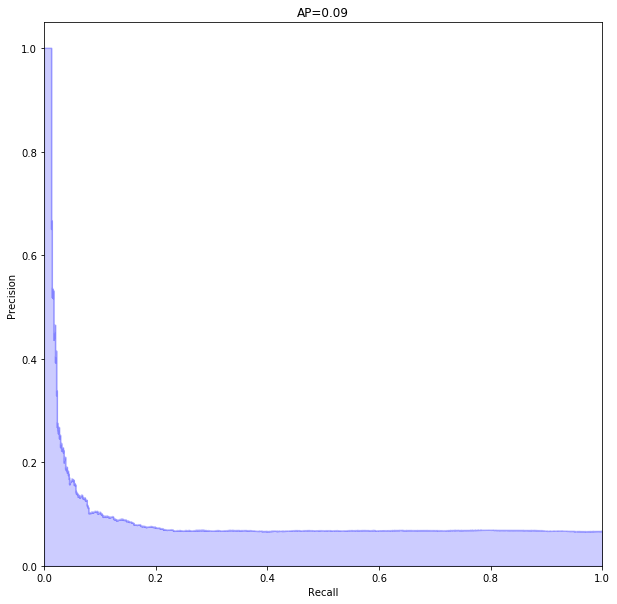

In [31]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
pr_curve(closest_pval.rank() <= 1000, score_pcnet_weighted, ax)

In [32]:
score_pcnet_weighted.to_csv('./results/pcnet_score_weighted.tsv', sep='\t')

In [33]:
score_nwnet = personal_gwap(nwnet, closest_pval, weight='post_prob')

0.085231800847410083

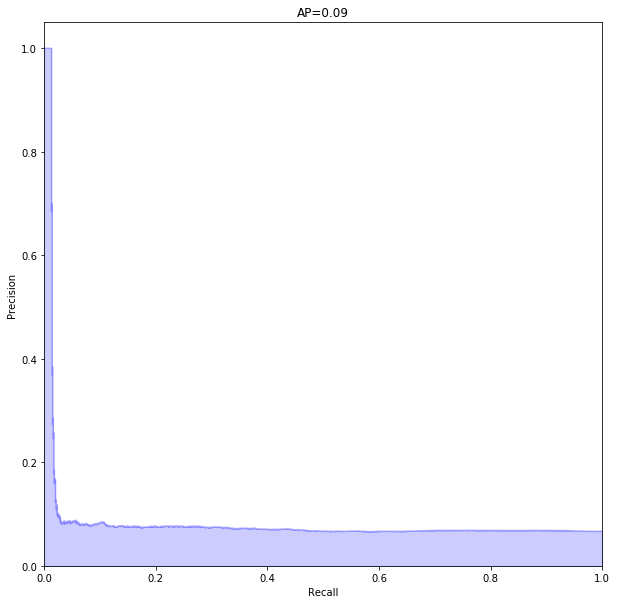

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
pr_curve(closest_pval.rank() <= 1000, score_nwnet, ax)

### save scores for downstream use

In [35]:
score_pcnet.to_csv('./results/pcnet_score.tsv', sep='\t')
score_pcnet_weighted.to_csv('./results/pcnet_score_weighted.tsv', sep='\t')
score_nwnet.to_csv('./results/score_nwnet_weighted.tsv', sep='\t')

### import scores if starting here

In [36]:
score_pcnet = pd.read_csv('./results/pcnet_score.tsv', sep='\t', index_col=0, header=None, names=['gene', 'score'])
score_pcnet_weighted = pd.read_csv('./results/pcnet_score_weighted.tsv', sep='\t', index_col=0, header=None, names=['gene', 'score'])
score_nwnet = pd.read_csv('./results/score_nwnet_weighted.tsv', sep='\t', index_col=0, header=None, names=['gene', 'score'])

### Evaluate overlap of sets

In [37]:
pcnet_1000 = (score_pcnet[score_pcnet.score.rank(ascending=False) <= 1000].index.values)
pcnet_w_1000 = (score_pcnet_weighted[score_pcnet_weighted.score.rank(ascending=False) <= 1000].index.values)
score_nwnet = (score_nwnet[score_nwnet.score.rank(ascending=False) <= 1000].index.values)
gwas_1000 = carlin_gene_snps[carlin_gene_snps.rank() <= 1000].index.values

In [38]:
len(set(pcnet_1000).intersection(pcnet_w_1000))

836

In [39]:
len(set(pcnet_1000).intersection(score_nwnet))

22

In [40]:
len(set(score_nwnet).intersection(pcnet_w_1000))

23

In [41]:
len( (set(pcnet_1000).intersection(pcnet_w_1000)).intersection(score_nwnet) )

21

# Internal Validation
_____
Validation will be done by using 60% of top 1000 genes to propagate the network.  
We will then test our ability to recover the other 40 top genes in our top 100 re-ranked genes

In [27]:
def eval_personal_gwap(G, gwas_res, ax,
                       n_iter=3,
                       sig_cutoff=8,
                       alpha=0.85,
                       max_iter=100):
    
    # initialize plot
    plt.figure()
    # initialize list to store scores
    pr_scores = []
    ap_scores = []
    for i in range(n_iter):
        start = time.time()
        print('performing training iteration:', i + 1)
        # get training and test genes
        train_genes, test_genes = train_test_split(gwas_res[gwas_res.rank() <= 1000],
                                           train_size=0.6)
        # create boolean testing vector
        y_test = pd.Series(dict(zip(closest_pval.index.values,
                                    closest_pval.index.isin(test_genes.index))))
        # score using gwap
        y_score = personal_gwap(G, train_genes,
                                sig_cutoff=sig_cutoff,
                                alpha=alpha,
                                max_iter=max_iter)
        # calculate pr curve and average precision
        ap = pr_curve(y_test, y_score, ax=ax)
        # store pagerank scores
        pr_scores.append(y_score)
        # store average precision
        ap_scores.append(ap)
        end = time.time()
        print('calculation time:', end-start)
    return y_score, ap_scores

evaluate different parameters of alpha

performing training iteration: 1
Gene
MKL1      0.000978
SORBS2    0.000158
YJEFN3    0.000170
TXNRD2    0.000010
DDX24     0.001052
Name: TopSNP P-Value, dtype: float64
calculation time: 130.689195394516
performing training iteration: 2
Gene
SIX2       0.000189
MAPK6      0.000828
TCF20      0.000185
ZNF214     0.001170
CCDC122    0.000355
Name: TopSNP P-Value, dtype: float64
calculation time: 100.57608485221863
performing training iteration: 3
Gene
MMD         0.000839
DNAH9       0.000963
CEACAM16    0.000732
SLC14A2     0.000063
SSBP3       0.000929
Name: TopSNP P-Value, dtype: float64
calculation time: 118.59797835350037
performing training iteration: 1
Gene
SERPINF1    0.000033
HIST1H1C    0.000002
NRBP2       0.000096
DDAH1       0.001038
TRAF3       0.000286
Name: TopSNP P-Value, dtype: float64
calculation time: 111.88065767288208
performing training iteration: 2
Gene
SMU1        7.923830e-04
EXT1        4.341930e-04
TMEM63C     6.756840e-04
ATP6V0A1    6.363390e-04
PRSS16     

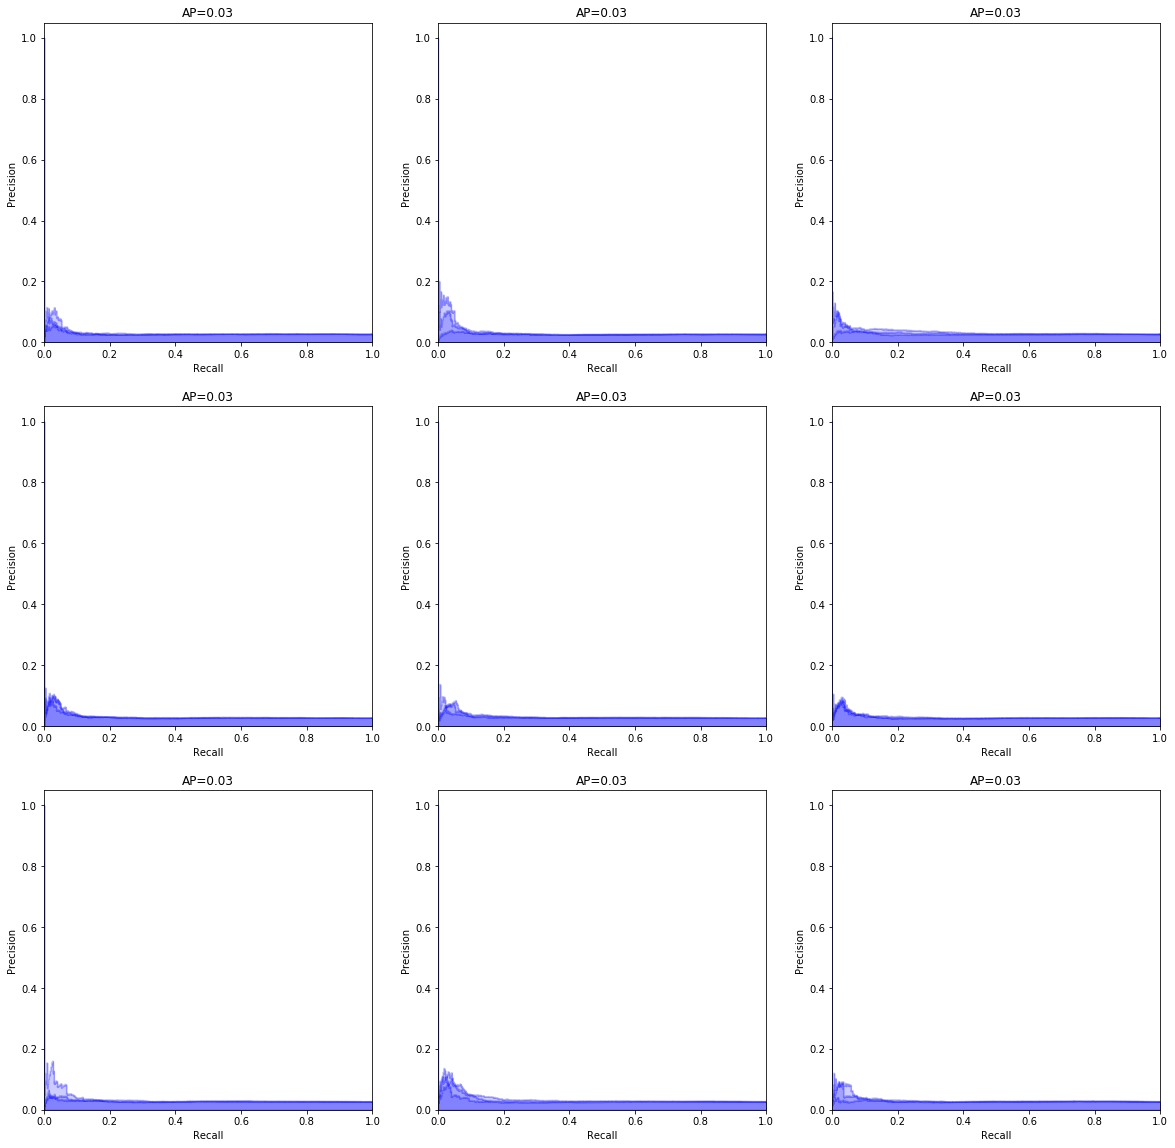

In [140]:
# set random seed
np.random.seed(1902)

count=0
ap_score_dict = {}
pr_score_dict = {}
alpha_range = np.arange(0.05, 0.95, 0.1)

fig, axs = plt.subplots(3, 3, figsize=(20, 20))


for alpha in np.arange(0.05, 0.95, 0.1):
    pr_scores, ap_scores = eval_personal_gwap(pcnet,
                                         closest_pval,
                                         np.ravel(axs)[count],
                                         alpha=alpha,
                                         n_iter=3)
    ap_score_dict[alpha] = ap_scores
    pr_score_dict[alpha] = pr_scores
    
    count += 1

performing training iteration: 1
Gene
MKL1      0.000978
SORBS2    0.000158
YJEFN3    0.000170
TXNRD2    0.000010
DDX24     0.001052
Name: TopSNP P-Value, dtype: float64
calculation time: 156.18366742134094
performing training iteration: 2
Gene
SIX2       0.000189
MAPK6      0.000828
TCF20      0.000185
ZNF214     0.001170
CCDC122    0.000355
Name: TopSNP P-Value, dtype: float64
calculation time: 179.73646759986877
performing training iteration: 3
Gene
MMD         0.000839
DNAH9       0.000963
CEACAM16    0.000732
SLC14A2     0.000063
SSBP3       0.000929
Name: TopSNP P-Value, dtype: float64
calculation time: 168.4197437763214
performing training iteration: 1
Gene
SERPINF1    0.000033
HIST1H1C    0.000002
NRBP2       0.000096
DDAH1       0.001038
TRAF3       0.000286
Name: TopSNP P-Value, dtype: float64
calculation time: 169.13753652572632
performing training iteration: 2
Gene
SMU1        7.923830e-04
EXT1        4.341930e-04
TMEM63C     6.756840e-04
ATP6V0A1    6.363390e-04
PRSS16    

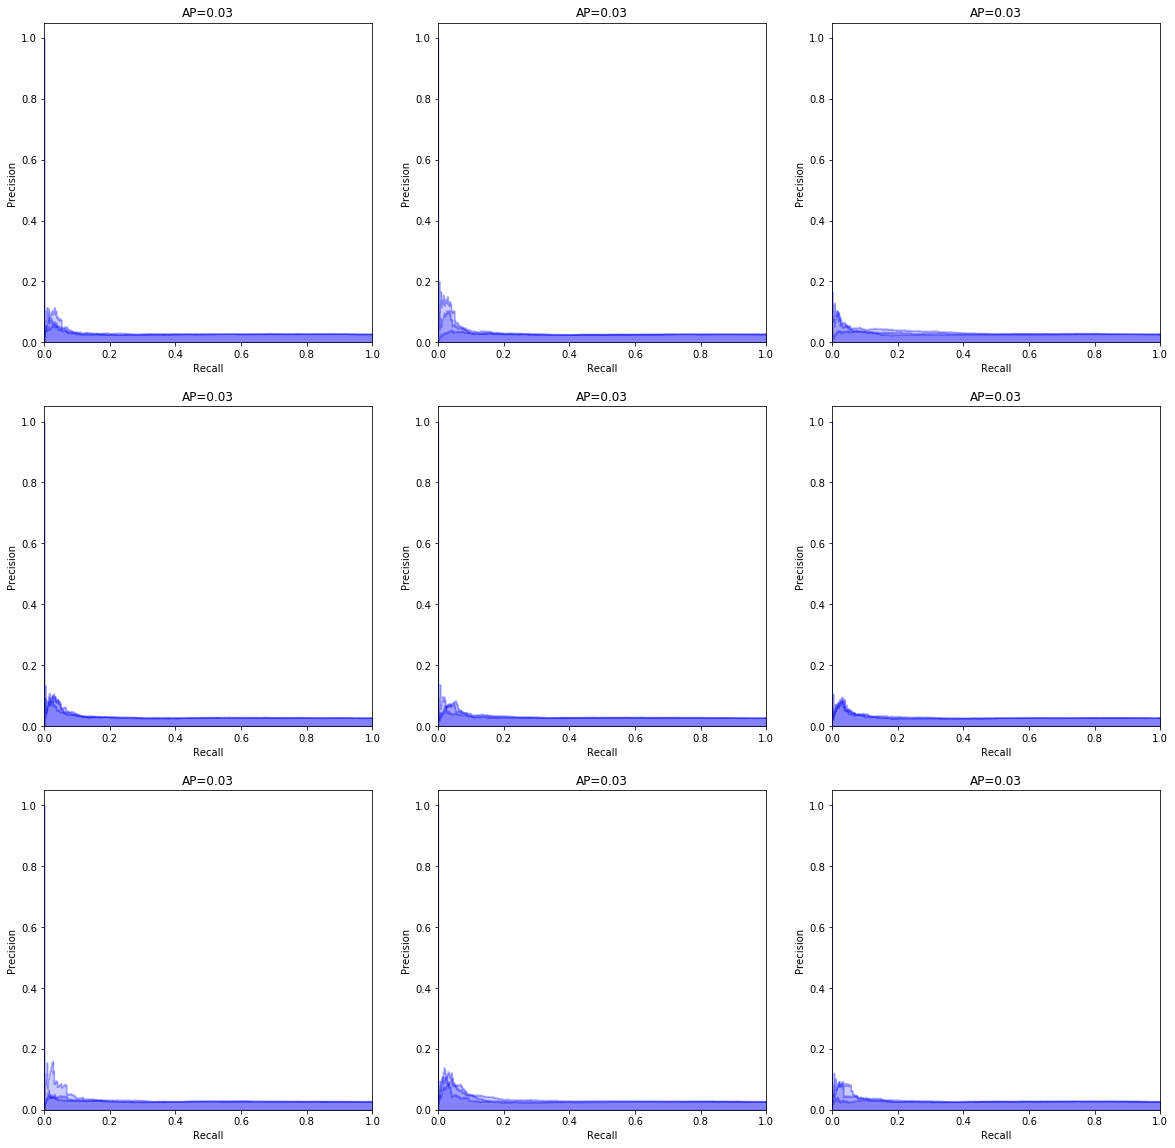

In [142]:
# set random seed
np.random.seed(1902)

count=0
ap_score_dict_wt = {}
pr_score_dict_wt = {}
alpha_range = np.arange(0.05, 0.95, 0.1)

fig, axs = plt.subplots(3, 3, figsize=(20, 20))


for alpha in np.arange(0.05, 0.95, 0.1):
    pr_scores, ap_scores = eval_personal_gwap(pcnet_wt,
                                         closest_pval,
                                         np.ravel(axs)[count],
                                         alpha=alpha,
                                         n_iter=3)
    ap_score_dict_wt[alpha] = ap_scores
    pr_score_dict_wt[alpha] = pr_scores
    
    count += 1

In [143]:
# create score dict for plotting
ap_scores = pd.DataFrame(ap_score_dict).T
ap_scores['average'] = ap_scores.mean(1)
ap_scores['standard_dev'] = ap_scores.std(1)
ap_scores.index.rename('alpha', inplace=True)
ap_scores.reset_index(inplace=True)
ap_scores.to_csv('./results/avg_precision_pcnet.tsv', sep='\t')

In [144]:
# create score dict for plotting
ap_scores_wt = pd.DataFrame(ap_score_dict_wt).T
ap_scores_wt['average'] = ap_scores_wt.mean(1)
ap_scores_wt['standard_dev'] = ap_scores.std(1)
ap_scores_wt.index.rename('alpha', inplace=True)
ap_scores_wt.reset_index(inplace=True)
ap_scores_wt.to_csv('./results/avg_precision_pcnet_wt.tsv', sep='\t')

### Load average precision graphs if starting from here 

In [ ]:
ap_scores = pd.read_csv('./results/avg_precision_pcnet_wt.tsv', sep='\t')
ap_scores_wt = pd.read_csv('./results/avg_precision_pcnet_wt.tsv', sep='\t')

### Plot our average precision

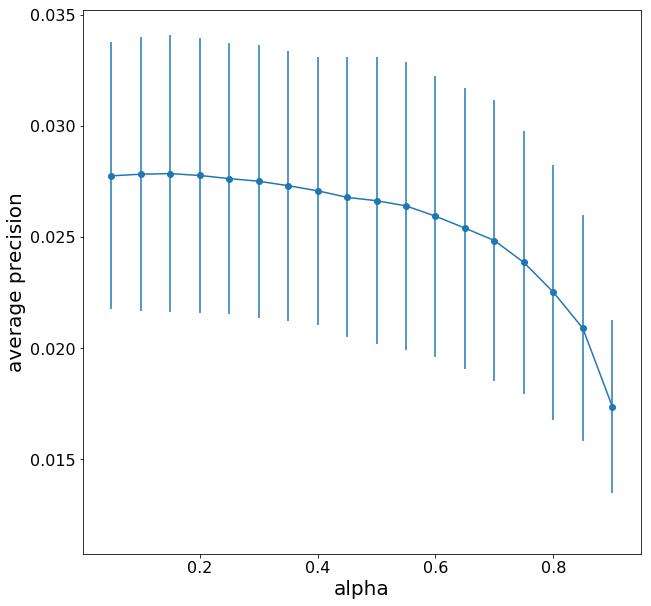

In [139]:
plt.figure(figsize=(10,10))
plt.scatter(ap_scores.alpha, ap_scores.average)
plt.errorbar(x=ap_scores.alpha, y=ap_scores.average,
             yerr=ap_scores.standard_dev)
plt.xlabel('alpha', fontsize=20)
plt.ylabel('average precision', fontsize=20)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)


### Evaluate ranked list in the retrieval of curated schizophrenia genes

In [61]:


harmonize_scz = 'http://amp.pharm.mssm.edu/Harmonizome/api/1.0/gene_set/Schizophrenia/CTD+Gene-Disease+Associations'
scz_json = json.loads(requests.get(harmonize_scz).text)['associations']
# extract genes from database
scz_genes = [gene['gene']['symbol'] for gene in scz_json]

harmonize_bpd = 'http://amp.pharm.mssm.edu/Harmonizome/api/1.0/gene_set/Bipolar+Disorder/CTD+Gene-Disease+Associations'
bpd_json = json.loads(requests.get(harmonize_scz).text)['associations']


omim genes taken from: https://www.omim.org/entry/181500?search=schizophrenia&highlight=schizophrenia

In [62]:
scz_omim = ['MTHFR', 'CHI3L1', 'DISC2', 'SYN2', 'DRD3', 'SCZD1', 'SCZD3', 'SCZD5', 'SCZD6', 'SCZD11', 'SCZD2',
            'HTR2A', 'DAOA', 'AKT1', 'SCZD8', 'COMT', 'RTN4R', 'APOL4', 'APOL2']

how many genes from curated list are in our top 1000 vs gwas top 1000

In [76]:
def score_overlap(test, score, n_genes=1000):
    genes = list(score[score.rank(ascending=False) <= n_genes].index)
    overlap = set(genes).intersection(set(test))
    print(len(overlap), 'genes overlap between target and top', n_genes, 'test genes')
    return (len(overlap))

def pull_harmonize_api(url):
    import json
    import requests
    
    json_file = json.loads(requests.get(url).text)['associations']
    return [gene['gene']['symbol'] for gene in json_file]

In [77]:
scz_harmonize = pull_harmonize_api(
    'http://amp.pharm.mssm.edu/Harmonizome/api/1.0/gene_set/Schizophrenia/CTD+Gene-Disease+Associations')
bpd_harmonize = pull_harmonize_api(
    'http://amp.pharm.mssm.edu/Harmonizome/api/1.0/gene_set/Bipolar+Disorder/CTD+Gene-Disease+Associations')

In [67]:
gwas_log10 = np.abs(np.log10(closest_pval))

In [145]:
scz_harm_scores = [score_overlap(scz_harmonize, gwas_log10),
                   score_overlap(scz_harmonize, score_pcnet),
                   score_overlap(scz_harmonize, score_pcnet_weighted),
                   score_overlap(scz_harmonize, score_nwnet)]

23 genes overlap between target and top 1000 test genes
33 genes overlap between target and top 1000 test genes
33 genes overlap between target and top 1000 test genes
6 genes overlap between target and top 1000 test genes


In [146]:
bpd_harm_scores = [score_overlap(bpd_harmonize, gwas_log10),
                   score_overlap(bpd_harmonize, score_pcnet),
                   score_overlap(bpd_harmonize, score_pcnet_weighted),
                   score_overlap(bpd_harmonize, score_nwnet)]

29 genes overlap between target and top 1000 test genes
55 genes overlap between target and top 1000 test genes
46 genes overlap between target and top 1000 test genes
8 genes overlap between target and top 1000 test genes


In [157]:
overlap_df = pd.DataFrame([scz_harm_scores, bpd_harm_scores],
                          index=['scz_harmonizome', 'bipolar_harmonizome'],
                          columns=['GWAS', 'PCNet', 'PCNet_weighted', 'GIANT']).T
            

In [158]:
overlap_df

,scz_harmonizome,bipolar_harmonizome
GWAS,23,29
PCNet,33,55
PCNet_weighted,33,46
GIANT,6,8


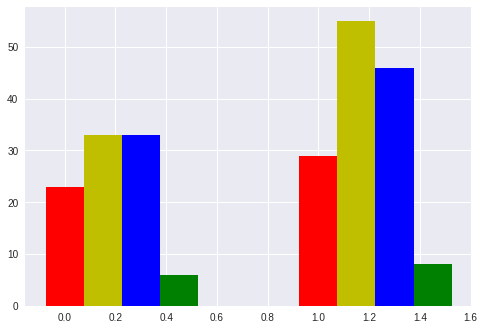

In [169]:
N=2
fig, ax = plt.subplots()
ind = np.arange(N)
width=0.15
p1 = ax.bar(ind, overlap_df.loc['GWAS', :],
            width, color='r')
p2 = ax.bar(ind + width, overlap_df.loc['PCNet', :], width,
            color='y')
p3 = ax.bar(ind + 2*width, overlap_df.loc['PCNet_weighted', :], width,
            color='b')
p4 = ax.bar(ind + 3*width, overlap_df.loc['GIANT', :], width,
            color='g')

ax.set_title('Genes Recovered in Top 1000')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Schizophrenia Harmonizome', 'Bipolar Harmonizome'))

ax.legend((p1[0], p2[0], p3[0], p4[0]),
          ('GWAS', 'GWAP - PCNET', 'GWAP - P'))
ax.yaxis.set_units(inch)
ax.autoscale_view()